## Lab: Numerical Methods for Nonlinear Equations and Systems

### Goal
Study numerical methods for solving:
1. A single nonlinear equation $f(x) = 0$
2. A system of nonlinear equations $\mathbf{F}(\mathbf{x}) = \mathbf{0}$

We analyze convergence behavior and error reduction for each method.

---

### Methods for a single equation $f(x) = 0$

#### 0) Bisection Method
Given an interval $[a, b]$ with $f(a) \cdot f(b) < 0$, we repeatedly bisect:
$$
c = \frac{a + b}{2}
$$
- If $f(a) \cdot f(c) < 0$, set $b \leftarrow c$
- Otherwise, set $a \leftarrow c$

**Convergence:** Linear with rate $\frac{1}{2}$:
$$
|e_{k+1}| = \frac{1}{2}|e_k|, \quad |e_k| \leq \frac{b_0 - a_0}{2^{k+1}}
$$

#### 1) Simple Iteration (Fixed-Point Iteration)
Rewrite $f(x) = 0$ as $x = g(x)$ and iterate:
$$
x_{k+1} = g(x_k)
$$
**Convergence:** If $|g'(x^*)| < 1$ near the root, linear convergence with rate $q = |g'(x^*)|$:
$$
|e_{k+1}| \approx q \cdot |e_k|
$$

#### 2) Newton's Method
Use the tangent line approximation:
$$
x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}
$$
**Convergence:** Quadratic near simple roots:
$$
|e_{k+1}| \approx \frac{|f''(x^*)|}{2|f'(x^*)|} |e_k|^2
$$

#### 3) Modified Newton's Method
Use the derivative at the initial point throughout:
$$
x_{k+1} = x_k - \frac{f(x_k)}{f'(x_0)}
$$
**Convergence:** Linear (avoids recomputing derivatives each iteration)

---

### Methods for systems $\mathbf{F}(\mathbf{x}) = \mathbf{0}$

#### Simple Iteration
Rewrite as $\mathbf{x} = \mathbf{G}(\mathbf{x})$ and iterate:
$$
\mathbf{x}_{k+1} = \mathbf{G}(\mathbf{x}_k)
$$

#### Newton's Method for Systems
$$
\mathbf{x}_{k+1} = \mathbf{x}_k - J(\mathbf{x}_k)^{-1} \mathbf{F}(\mathbf{x}_k)
$$
where $J(\mathbf{x})$ is the Jacobian matrix with entries $J_{ij} = \frac{\partial F_i}{\partial x_j}$.

#### Modified Newton's Method for Systems
Use the Jacobian at the initial point only:
$$
\mathbf{x}_{k+1} = \mathbf{x}_k - J(\mathbf{x}_0)^{-1} \mathbf{F}(\mathbf{x}_k)
$$

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [12]:
def sci1(x):
    try:
        x = float(x)
    except Exception:
        return ""
    if not np.isfinite(x):
        return ""
    if x == 0.0:
        return "0"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / (10 ** exp)
    mant = np.round(mant, 1)
    if abs(mant) >= 10:
        mant = mant / 10
        exp += 1
    return f"{mant:.1f}e{exp:+d}"

def rel_err_scalar(x, x_star):
    if x_star is None:
        return np.nan
    return abs(x - x_star) / max(1.0, abs(x_star))

def rel_err_vec(x, x_star, ord=2):
    if x_star is None:
        return np.nan
    x = np.asarray(x, dtype=float)
    x_star = np.asarray(x_star, dtype=float)
    return np.linalg.norm(x - x_star, ord=ord) / max(1.0, np.linalg.norm(x_star, ord=ord))


In [13]:
def plot_scalar_histories(histories, title, x_star=None):
    plt.figure(figsize=(8.6, 4.6))
    for name, df in histories.items():
        if x_star is not None and "abs_err" in df.columns:
            y = np.maximum(df["abs_err"].to_numpy(dtype=float), 2**-50)
            plt.semilogy(df["iter"], y, label=name)
        else:
            y = np.maximum(np.abs(df["f"].to_numpy(dtype=float)), 2**-50)
            plt.semilogy(df["iter"], y, label=f"{name}: |f(x)|")
    plt.xlabel("Iteration")
    plt.ylabel("Absolute error" if (x_star is not None) else "Residual |f(x)|")
    plt.title(title)
    plt.grid(True, which="both", alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_system_histories(histories, title, x_star=None, ord=2):
    plt.figure(figsize=(8.6, 4.6))
    for name, df in histories.items():
        if x_star is not None and "abs_err" in df.columns:
            y = np.maximum(df["abs_err"].to_numpy(dtype=float), 2**-50)
            plt.semilogy(df["iter"], y, label=name)
        else:
            y = np.maximum(df["res_norm"].to_numpy(dtype=float), 2**-50)
            plt.semilogy(df["iter"], y, label=f"{name}: ||F||")
    plt.xlabel("Iteration")
    plt.ylabel("Absolute error ||x-x*||" if (x_star is not None) else "Residual norm ||F(x)||")
    plt.title(title)
    plt.grid(True, which="both", alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [14]:
def bisection(f, a, b, x_tol=1e-12, f_tol=1e-12, max_iter=200, x_star=None):
    a = float(a); b = float(b)
    fa = float(f(a)); fb = float(f(b))
    if not np.isfinite(fa) or not np.isfinite(fb):
        raise ValueError("Non-finite endpoint value(s). Pick a bracket inside the domain of f.")
    if fa * fb > 0:
        raise ValueError("Bisection requires a sign change: f(a)*f(b) <= 0.")

    rows = []
    for k in range(max_iter + 1):
        m = 0.5 * (a + b)
        fm = float(f(m))
        width = b - a
        err_est = 0.5 * abs(width)

        rows.append({
            "iter": k,
            "a": a, "b": b,
            "x": m, "f": fm,
            "width": width,
            "err_est": err_est,
            "abs_err": abs(m - x_star) if x_star is not None else np.nan,
            "rel_err": rel_err_scalar(m, x_star) if x_star is not None else np.nan,
        })

        if abs(fm) <= f_tol or err_est <= x_tol * (1.0 + abs(m)):
            break

        if fa * fm < 0:
            b, fb = m, fm
        else:
            a, fa = m, fm

    hist = pd.DataFrame(rows)
    return float(hist.iloc[-1]["x"]), hist

def fixed_point(phi, x0, f=None, x_tol=1e-12, f_tol=1e-12, max_iter=200, x_star=None):
    x = float(x0)
    rows = []
    for k in range(max_iter + 1):
        fx = float(f(x)) if f is not None else np.nan
        rows.append({
            "iter": k,
            "x": x,
            "f": fx,
            "step": np.nan,
            "abs_err": abs(x - x_star) if x_star is not None else np.nan,
            "rel_err": rel_err_scalar(x, x_star) if x_star is not None else np.nan,
        })

        if f is not None and np.isfinite(fx) and abs(fx) <= f_tol and k > 0:
            break

        x_new = float(phi(x))
        step = x_new - x
        rows[-1]["step"] = step

        if abs(step) <= x_tol * (1.0 + abs(x_new)) and k > 0:
            x = x_new
            rows.append({
                "iter": k + 1,
                "x": x,
                "f": float(f(x)) if f is not None else np.nan,
                "step": 0.0,
                "abs_err": abs(x - x_star) if x_star is not None else np.nan,
                "rel_err": rel_err_scalar(x, x_star) if x_star is not None else np.nan,
            })
            break

        x = x_new

    hist = pd.DataFrame(rows)
    return float(hist.iloc[-1]["x"]), hist

def newton(f, df, x0, x_tol=1e-12, f_tol=1e-12, max_iter=50, x_star=None):
    x = float(x0)
    rows = []
    for k in range(max_iter + 1):
        fx = float(f(x))
        dfx = float(df(x))
        rows.append({
            "iter": k,
            "x": x,
            "f": fx,
            "df": dfx,
            "step": np.nan,
            "abs_err": abs(x - x_star) if x_star is not None else np.nan,
            "rel_err": rel_err_scalar(x, x_star) if x_star is not None else np.nan,
        })

        if abs(fx) <= f_tol and k > 0:
            break
        if dfx == 0.0 or not np.isfinite(dfx):
            raise ZeroDivisionError(f"Newton failed: derivative is zero/non-finite at iter={k}, x={x}.")

        step = -fx / dfx
        rows[-1]["step"] = step
        x_new = x + step

        if abs(step) <= x_tol * (1.0 + abs(x_new)) and k > 0:
            x = float(x_new)
            rows.append({
                "iter": k + 1,
                "x": x,
                "f": float(f(x)),
                "df": float(df(x)),
                "step": 0.0,
                "abs_err": abs(x - x_star) if x_star is not None else np.nan,
                "rel_err": rel_err_scalar(x, x_star) if x_star is not None else np.nan,
            })
            break

        x = float(x_new)

    hist = pd.DataFrame(rows)
    return float(hist.iloc[-1]["x"]), hist

def modified_newton(f, df, x0, x_tol=1e-12, f_tol=1e-12, max_iter=50, x_star=None):
    x = float(x0)
    df0 = float(df(x0))
    if df0 == 0.0 or not np.isfinite(df0):
        raise ZeroDivisionError("Modified Newton failed: df(x0) is zero/non-finite.")

    rows = []
    for k in range(max_iter + 1):
        fx = float(f(x))
        rows.append({
            "iter": k,
            "x": x,
            "f": fx,
            "df0": df0,
            "step": np.nan,
            "abs_err": abs(x - x_star) if x_star is not None else np.nan,
            "rel_err": rel_err_scalar(x, x_star) if x_star is not None else np.nan,
        })

        if abs(fx) <= f_tol and k > 0:
            break

        step = -fx / df0
        rows[-1]["step"] = step
        x_new = x + step

        if abs(step) <= x_tol * (1.0 + abs(x_new)) and k > 0:
            x = float(x_new)
            rows.append({
                "iter": k + 1,
                "x": x,
                "f": float(f(x)),
                "df0": df0,
                "step": 0.0,
                "abs_err": abs(x - x_star) if x_star is not None else np.nan,
                "rel_err": rel_err_scalar(x, x_star) if x_star is not None else np.nan,
            })
            break

        x = float(x_new)

    hist = pd.DataFrame(rows)
    return float(hist.iloc[-1]["x"]), hist


In [15]:
def lu_decomposition_pp(A):
    A = np.array(A, dtype=float, copy=True)
    n = A.shape[0]
    U = A.copy()
    L = np.eye(n, dtype=float)
    P = np.arange(n)

    for k in range(n - 1):
        pivot = k + np.argmax(np.abs(U[k:, k]))
        if U[pivot, k] == 0:
            raise np.linalg.LinAlgError("Singular matrix during LU decomposition.")

        if pivot != k:
            U[[k, pivot]] = U[[pivot, k]]
            P[[k, pivot]] = P[[pivot, k]]
            if k > 0:
                L[[k, pivot], :k] = L[[pivot, k], :k]

        for i in range(k + 1, n):
            L[i, k] = U[i, k] / U[k, k]
            U[i, k:] -= L[i, k] * U[k, k:]
            U[i, k] = 0.0

    return P, L, U

def lu_solve(P, L, U, b):
    b = np.asarray(b, dtype=float)
    bp = b[P]
    n = L.shape[0]

    y = np.zeros(n, dtype=float)
    for i in range(n):
        y[i] = bp[i] - L[i, :i] @ y[:i]

    x = np.zeros(n, dtype=float)
    for i in range(n - 1, -1, -1):
        if U[i, i] == 0:
            raise np.linalg.LinAlgError("Singular matrix in back substitution.")
        x[i] = (y[i] - U[i, i+1:] @ x[i+1:]) / U[i, i]

    return x


In [16]:
def fixed_point_system(phi, x0, F=None, x_tol=1e-12, f_tol=1e-12, max_iter=200, x_star=None, ord=2):
    x = np.asarray(x0, dtype=float).copy()
    rows = []
    for k in range(max_iter + 1):
        Fx = np.asarray(F(x), dtype=float) if F is not None else None
        res = float(np.linalg.norm(Fx, ord=ord)) if Fx is not None else np.nan

        rows.append({
            "iter": k,
            "x": x.copy(),
            "res_norm": res,
            "step_norm": np.nan,
            "abs_err": float(np.linalg.norm(x - x_star, ord=ord)) if x_star is not None else np.nan,
            "rel_err": rel_err_vec(x, x_star, ord=ord) if x_star is not None else np.nan,
        })

        if F is not None and np.isfinite(res) and res <= f_tol and k > 0:
            break

        x_new = np.asarray(phi(x), dtype=float)
        step = x_new - x
        step_norm = float(np.linalg.norm(step, ord=ord))
        rows[-1]["step_norm"] = step_norm

        if step_norm <= x_tol * (1.0 + float(np.linalg.norm(x_new, ord=ord))) and k > 0:
            x = x_new
            rows.append({
                "iter": k + 1,
                "x": x.copy(),
                "res_norm": float(np.linalg.norm(np.asarray(F(x), dtype=float), ord=ord)) if F is not None else np.nan,
                "step_norm": 0.0,
                "abs_err": float(np.linalg.norm(x - x_star, ord=ord)) if x_star is not None else np.nan,
                "rel_err": rel_err_vec(x, x_star, ord=ord) if x_star is not None else np.nan,
            })
            break

        x = x_new

    hist = pd.DataFrame(rows)
    return x, hist

def newton_system(F, J, x0, x_tol=1e-12, f_tol=1e-12, max_iter=50, x_star=None, ord=2):
    x = np.asarray(x0, dtype=float).copy()
    rows = []
    for k in range(max_iter + 1):
        Fx = np.asarray(F(x), dtype=float)
        res = float(np.linalg.norm(Fx, ord=ord))

        rows.append({
            "iter": k,
            "x": x.copy(),
            "res_norm": res,
            "step_norm": np.nan,
            "abs_err": float(np.linalg.norm(x - x_star, ord=ord)) if x_star is not None else np.nan,
            "rel_err": rel_err_vec(x, x_star, ord=ord) if x_star is not None else np.nan,
        })

        if res <= f_tol and k > 0:
            break

        A = np.asarray(J(x), dtype=float)
        try:
            step = np.linalg.solve(A, -Fx)
        except np.linalg.LinAlgError as e:
            raise np.linalg.LinAlgError(f"Newton system failed at iter={k}: {e}")

        step_norm = float(np.linalg.norm(step, ord=ord))
        rows[-1]["step_norm"] = step_norm

        x_new = x + step
        if step_norm <= x_tol * (1.0 + float(np.linalg.norm(x_new, ord=ord))) and k > 0:
            x = x_new
            rows.append({
                "iter": k + 1,
                "x": x.copy(),
                "res_norm": float(np.linalg.norm(np.asarray(F(x), dtype=float), ord=ord)),
                "step_norm": 0.0,
                "abs_err": float(np.linalg.norm(x - x_star, ord=ord)) if x_star is not None else np.nan,
                "rel_err": rel_err_vec(x, x_star, ord=ord) if x_star is not None else np.nan,
            })
            break

        x = x_new

    hist = pd.DataFrame(rows)
    return x, hist

def modified_newton_system(F, J, x0, x_tol=1e-12, f_tol=1e-12, max_iter=50, x_star=None, ord=2):
    x = np.asarray(x0, dtype=float).copy()
    A0 = np.asarray(J(x0), dtype=float)
    P, L, U = lu_decomposition_pp(A0)

    rows = []
    for k in range(max_iter + 1):
        Fx = np.asarray(F(x), dtype=float)
        res = float(np.linalg.norm(Fx, ord=ord))

        rows.append({
            "iter": k,
            "x": x.copy(),
            "res_norm": res,
            "step_norm": np.nan,
            "abs_err": float(np.linalg.norm(x - x_star, ord=ord)) if x_star is not None else np.nan,
            "rel_err": rel_err_vec(x, x_star, ord=ord) if x_star is not None else np.nan,
        })

        if res <= f_tol and k > 0:
            break

        step = lu_solve(P, L, U, -Fx)
        step_norm = float(np.linalg.norm(step, ord=ord))
        rows[-1]["step_norm"] = step_norm

        x_new = x + step
        if step_norm <= x_tol * (1.0 + float(np.linalg.norm(x_new, ord=ord))) and k > 0:
            x = x_new
            rows.append({
                "iter": k + 1,
                "x": x.copy(),
                "res_norm": float(np.linalg.norm(np.asarray(F(x), dtype=float), ord=ord)),
                "step_norm": 0.0,
                "abs_err": float(np.linalg.norm(x - x_star, ord=ord)) if x_star is not None else np.nan,
                "rel_err": rel_err_vec(x, x_star, ord=ord) if x_star is not None else np.nan,
            })
            break

        x = x_new

    hist = pd.DataFrame(rows)
    return x, hist


In [ ]:
# Equation 1: 2 tan x - x/2 + 1 = 0
f1  = lambda x: 2*np.tan(x) - x/2 + 1
df1 = lambda x: 2/(np.cos(x)**2) - 0.5

phi1 = lambda x: np.arctan(x/4 - 0.5)

a1, b1 = -0.6, -0.4
x0_1 = -0.5

x1_star, _ = bisection(f1, a1, b1, x_tol=1e-15, f_tol=1e-15, max_iter=500)
x1_star

-0.5713179028318806

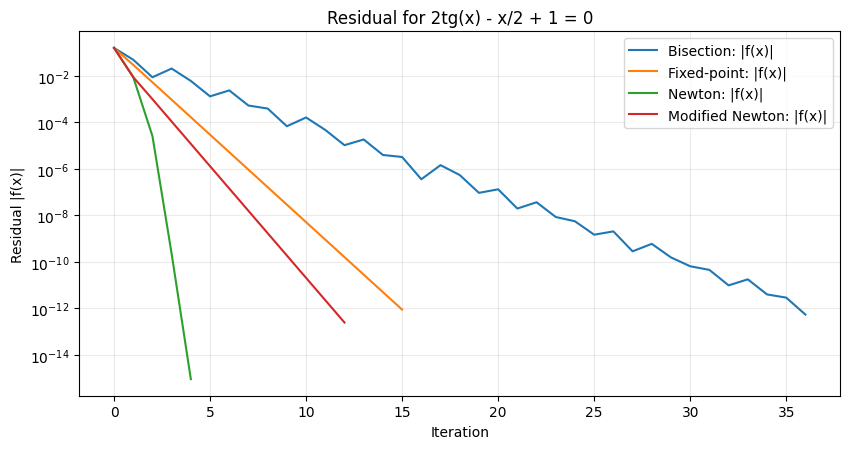

In [25]:
hist1 = {}

x_bis1, h_bis1 = bisection(f1, a1, b1, x_tol=1e-12, f_tol=1e-12, max_iter=200, x_star=x1_star)
hist1["Bisection"] = h_bis1

x_fp1, h_fp1 = fixed_point(phi1, x0_1, f=f1, x_tol=1e-12, f_tol=1e-12, max_iter=300, x_star=x1_star)
hist1["Fixed-point"] = h_fp1

x_n1, h_n1 = newton(f1, df1, x0_1, x_tol=1e-12, f_tol=1e-12, max_iter=50, x_star=x1_star)
hist1["Newton"] = h_n1

x_mn1, h_mn1 = modified_newton(f1, df1, x0_1, x_tol=1e-12, f_tol=1e-12, max_iter=80, x_star=x1_star)
hist1["Modified Newton"] = h_mn1

plot_scalar_histories(hist1, r"Residual for 2tg(x) - x/2 + 1 = 0")


In [26]:
rows = []
for name, df in hist1.items():
    rows.append({
        "method": name,
        "iters": int(df["iter"].iloc[-1]),
        "x_final": float(df["x"].iloc[-1]),
        "|f(x_final)|": float(abs(df["f"].iloc[-1])) if np.isfinite(df["f"].iloc[-1]) else np.nan,
        "|x-x*|": float(df["abs_err"].iloc[-1]) if "abs_err" in df.columns else np.nan,
        "rel_err": float(df["rel_err"].iloc[-1]) if "rel_err" in df.columns else np.nan,
    })
summary1 = pd.DataFrame(rows)

summary1_fmt = summary1.copy()
for c in ["x_final", "|f(x_final)|", "|x-x*|", "rel_err"]:
    summary1_fmt[c] = summary1_fmt[c].apply(sci1)

summary1_fmt


,method,iters,x_final,|f(x_final)|,|x-x*|,rel_err
0,Bisection,36,-5.7e-1,5.3e-13,2.3e-13,2.3e-13
1,Fixed-point,15,-5.7e-1,8.7e-13,3.7e-13,3.7e-13
2,Newton,4,-5.7e-1,1.1e-16,3.3e-16,3.3e-16
3,Modified Newton,12,-5.7e-1,2.4e-13,1.0e-13,1.0e-13


In [27]:
# Equation 2: x^2 - e^x/5 = 0
f2  = lambda x: x**2 - np.exp(x)/5
df2 = lambda x: 2*x - np.exp(x)/5

phi2 = lambda x: np.sqrt(np.exp(x)/5)

a2, b2 = 0.0, 1.0
x0_2 = 0.5

x2_star, _ = bisection(f2, a2, b2, x_tol=1e-15, f_tol=1e-15, max_iter=500)
x2_star


0.6052671213146184

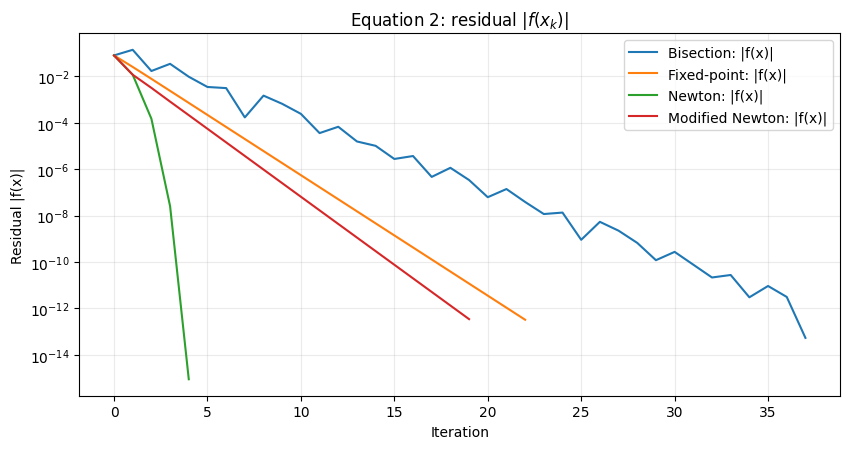

In [ ]:
hist2 = {}

x_bis2, h_bis2 = bisection(f2, a2, b2, x_tol=1e-12, f_tol=1e-12, max_iter=200, x_star=x2_star)
hist2["Bisection"] = h_bis2

x_fp2, h_fp2 = fixed_point(phi2, x0_2, f=f2, x_tol=1e-12, f_tol=1e-12, max_iter=500, x_star=x2_star)
hist2["Fixed-point"] = h_fp2

x_n2, h_n2 = newton(f2, df2, x0_2, x_tol=1e-12, f_tol=1e-12, max_iter=50, x_star=x2_star)
hist2["Newton"] = h_n2

x_mn2, h_mn2 = modified_newton(f2, df2, x0_2, x_tol=1e-12, f_tol=1e-12, max_iter=120, x_star=x2_star)
hist2["Modified Newton"] = h_mn2

plot_scalar_histories(hist2, r"x^2 - e^x/5 = 0 : residual $|f(x_k)|$")


In [30]:
rows = []
for name, df in hist2.items():
    rows.append({
        "method": name,
        "iters": int(df["iter"].iloc[-1]),
        "x_final": float(df["x"].iloc[-1]),
        "|f(x_final)|": float(abs(df["f"].iloc[-1])) if np.isfinite(df["f"].iloc[-1]) else np.nan,
        "|x-x*|": float(df["abs_err"].iloc[-1]) if "abs_err" in df.columns else np.nan,
        "rel_err": float(df["rel_err"].iloc[-1]) if "rel_err" in df.columns else np.nan,
    })
summary2 = pd.DataFrame(rows)

summary2_fmt = summary2.copy()
for c in ["x_final", "|f(x_final)|", "|x-x*|", "rel_err"]:
    summary2_fmt[c] = summary2_fmt[c].apply(sci1)

summary2_fmt


,method,iters,x_final,|f(x_final)|,|x-x*|,rel_err
0,Bisection,37,6.1e-1,5.4e-14,6.4e-14,6.4e-14
1,Fixed-point,22,6.1e-1,3.3e-13,3.9e-13,3.9e-13
2,Newton,4,6.1e-1,7.2e-16,1.0e-15,1.0e-15
3,Modified Newton,19,6.1e-1,3.5e-13,4.1e-13,4.1e-13


In [31]:
# System 1:
# cos(x - 1) + y = 0.5
# x - cos y = 3

F_sys1 = lambda v: np.array([
    np.cos(v[0] - 1) + v[1] - 0.5,
    v[0] - np.cos(v[1]) - 3.0
], dtype=float)

J_sys1 = lambda v: np.array([
    [-np.sin(v[0] - 1), 1.0],
    [1.0, np.sin(v[1])]
], dtype=float)

phi_sys1 = lambda v: np.array([
    3.0 + np.cos(v[1]),
    0.5 - np.cos(v[0] - 1)
], dtype=float)

x0_sys1 = np.array([3.2, 1.0], dtype=float)

x1_ref, _ = newton_system(F_sys1, J_sys1, x0_sys1, x_tol=1e-15, f_tol=1e-15, max_iter=60)
x1_ref


array([3.35591174, 1.20690682])

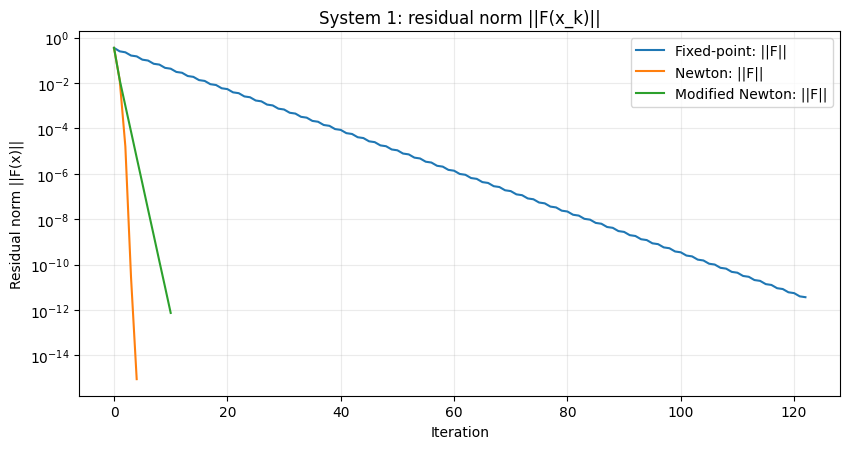

In [34]:
hist_sys1 = {}

x_fp_s1, h_fp_s1 = fixed_point_system(phi_sys1, x0_sys1, F=F_sys1, x_tol=1e-12, f_tol=1e-12, max_iter=400, x_star=x1_ref)
hist_sys1["Fixed-point"] = h_fp_s1

x_n_s1, h_n_s1 = newton_system(F_sys1, J_sys1, x0_sys1, x_tol=1e-12, f_tol=1e-12, max_iter=60, x_star=x1_ref)
hist_sys1["Newton"] = h_n_s1

x_m_s1, h_m_s1 = modified_newton_system(F_sys1, J_sys1, x0_sys1, x_tol=1e-12, f_tol=1e-12, max_iter=120, x_star=x1_ref)
hist_sys1["Modified Newton"] = h_m_s1

plot_system_histories(hist_sys1, "System 1: residual norm ||F(x_k)||")


In [35]:
rows = []
for name, df in hist_sys1.items():
    x_final = np.asarray(df["x"].iloc[-1], dtype=float)
    rows.append({
        "method": name,
        "iters": int(df["iter"].iloc[-1]),
        "x_final": x_final[0],
        "y_final": x_final[1],
        "||F||": float(df["res_norm"].iloc[-1]),
        "||x-x*||": float(df["abs_err"].iloc[-1]),
        "rel_err": float(df["rel_err"].iloc[-1]),
    })
summary_sys1 = pd.DataFrame(rows)

summary_sys1_fmt = summary_sys1.copy()
for c in ["x_final", "y_final", "||F||", "||x-x*||", "rel_err"]:
    summary_sys1_fmt[c] = summary_sys1_fmt[c].apply(sci1)

summary_sys1_fmt


,method,iters,x_final,y_final,||F||,||x-x*||,rel_err
0,Fixed-point,122,3.4e+0,1.2e+0,3.6e-12,2.6e-12,7.3e-13
1,Newton,4,3.4e+0,1.2e+0,0,0,0
2,Modified Newton,10,3.4e+0,1.2e+0,7.4e-13,5.3e-13,1.5e-13


In [36]:
# System 2:
# sin x - y = 1.32
# cos y - x = -0.85

F_sys2 = lambda v: np.array([
    np.sin(v[0]) - v[1] - 1.32,
    np.cos(v[1]) - v[0] + 0.85
], dtype=float)

J_sys2 = lambda v: np.array([
    [np.cos(v[0]), -1.0],
    [-1.0, -np.sin(v[1])]
], dtype=float)

phi_sys2 = lambda v: np.array([
    np.cos(v[1]) + 0.85,
    np.sin(v[0]) - 1.32
], dtype=float)

x0_sys2 = np.array([1.5, -0.3], dtype=float)

x2_ref, _ = newton_system(F_sys2, J_sys2, x0_sys2, x_tol=1e-15, f_tol=1e-15, max_iter=60)
x2_ref


array([ 1.79133861, -0.34422104])

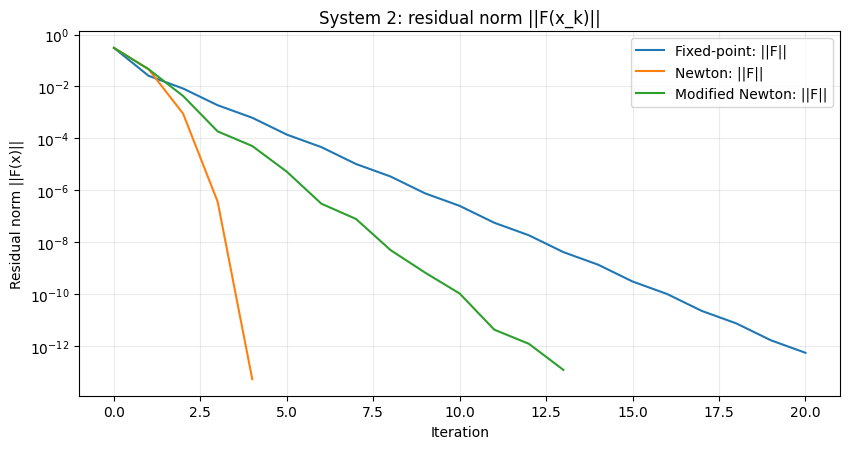

In [39]:
hist_sys2 = {}

x_fp_s2, h_fp_s2 = fixed_point_system(phi_sys2, x0_sys2, F=F_sys2, x_tol=1e-12, f_tol=1e-12, max_iter=600, x_star=x2_ref)
hist_sys2["Fixed-point"] = h_fp_s2

x_n_s2, h_n_s2 = newton_system(F_sys2, J_sys2, x0_sys2, x_tol=1e-12, f_tol=1e-12, max_iter=60, x_star=x2_ref)
hist_sys2["Newton"] = h_n_s2

x_m_s2, h_m_s2 = modified_newton_system(F_sys2, J_sys2, x0_sys2, x_tol=1e-12, f_tol=1e-12, max_iter=200, x_star=x2_ref)
hist_sys2["Modified Newton"] = h_m_s2

plot_system_histories(hist_sys2, "System 2: residual norm ||F(x_k)||")


In [38]:
rows = []
for name, df in hist_sys2.items():
    x_final = np.asarray(df["x"].iloc[-1], dtype=float)
    rows.append({
        "method": name,
        "iters": int(df["iter"].iloc[-1]),
        "x_final": x_final[0],
        "y_final": x_final[1],
        "||F||": float(df["res_norm"].iloc[-1]),
        "||x-x*||": float(df["abs_err"].iloc[-1]),
        "rel_err": float(df["rel_err"].iloc[-1]),
    })
summary_sys2 = pd.DataFrame(rows)

summary_sys2_fmt = summary_sys2.copy()
for c in ["x_final", "y_final", "||F||", "||x-x*||", "rel_err"]:
    summary_sys2_fmt[c] = summary_sys2_fmt[c].apply(sci1)

summary_sys2_fmt


,method,iters,x_final,y_final,||F||,||x-x*||,rel_err
0,Fixed-point,20,1.8e+0,-3.4e-1,5.5e-13,5.1e-13,2.8e-13
1,Newton,4,1.8e+0,-3.4e-1,5.3e-14,5.1e-14,2.8e-14
2,Modified Newton,13,1.8e+0,-3.4e-1,1.2e-13,1.1e-13,6.1e-14
